# Intro

요즘은 열심히 돈만 벌고 있으면 상대적 가난에 처하는, 돈 놀이가 유행한다. 집값은 하루가 멀다하고 상승하고, 뉴스에서는 코인으로 400억을 벌고 삼성을 퇴직했다는 기사가 나온다. 남이 잘 되는 것을 보고 있자니 배가 아프고 머리가 어질어질하여 타이레놀이 많이 필요할 때이다.
<br>
<br>
과연 내가 투자했어도 돈을 벌 수 있었을까? 벌 수 있었다면 부동산과 주식, 코인 중 어디에 투자해야 성공할 확률이 더 클까? 데이터를 보고 학습한 뒤 미래의 나는 "아빠는 그때 왜 투자 안했어?"소리 안들을 수 있게 준비해보자. 각 투자 전략들을 안전성과 수익성 측면에서 비교해 보겠다.

## 목차

1. [주택 투자](#1.-주택-투자)
 - [임대소득 투자법](#임대소득-투자법)
 - [매매차익 투자법](#매매차익-투자법)
2. [땅 투자](#2.-땅-투자)
3. [주식 투자](#3.-주식-투자)
4. [코인 투기](#4.-코인-투기)
5. [각 투자 간 상관성 분석](#5.-각-투자-간-상관성-분석)

In [1]:
# 시작에 앞서 한글 폰트설정

def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인
    
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows" :
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 꼭 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq > /dev/null
        
        import matplotlib.font_manager as fm
        
        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
        
    return font_family

# https://www.youtube.com/watch?v=9ovF2bqMME4
# 유튜버 "todaycode오늘코드"님의 영상 < KRX분석 [6/13] 데이터 시각화 도구 소개와 한글 폰트 설정 >
# 데이콘에서는 "Visualising Korea"로 활동하시는 듯 합니다.

In [2]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import FinanceDataReader as fdr
from pybithumb import Bithumb

from scipy.stats import chi2

import seaborn as sns
import matplotlib.pyplot as plt

font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rcParams['axes.unicode_minus'] = False
path = './data/'

In [3]:
# 최대 수익률을 계산 후 출력하는 함수
def print_revenue(data, column, event):
    print(f"근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 {event} 수익률은 : ", ((data[column].max()/data[column].min())-1)*100, "% 입니다.")

In [4]:
# 안전성 계산 후 출력하는 함수
def print_safety(data, column, event):
    count = 0
    for n in range(data.shape[0]-1):
        if data[column][n]<data[column][n+1]:
            count += 1
    print(f"{event}가 상승한 날은 전체", data.shape[0], "일 중에", count, "일 이다.")
    print("따라서", (count/data.shape[0])*100, "%의 확률로 투자 수익을 낼 수 있다.")

## 1. 주택 투자
주택 투자에도 다양한 방법이 존재하는 듯 하다. 얕은 지식으로 알아본 결과, 주택 투자법은 크게 두가지로 나뉜다고 한다. 바로 __임대소득 투자법__ 과 __매매차익 투자법__ 이다.

|  <center></center> |  <center>임대소득 투자법</center> |  <center>매매차익 투자법</center> |
|--------|:--------|:--------|
| <center> **정의** </center> |임대료를 받는 투자법<br>예시: 1억 3천만원에 오피스텔을<br>사서 보증금 천만원에 월세를 60만원<br>받는다면 임대소득 발생 | 매매차익으로 수익을 얻는 투자법<br>예시: 아파트를 3억원에 사서 5억원에<br>매도하면 2억원의 양도차익 발생 |
| <center> **특징** </center> | <center> 매달 현금흐름 발생 </center> | <center> 매도했을 때만 수익 발생 </center> |

### 임대소득 투자법
임대소득 투자의 핵심은 금리와 수익률이다. 오피스텔을 사서 월세로 임대소득을 취한다고 해서, 무조건 이득인 것은 아니다. 은행 금리와 비교 하였을 때 월세 수익률이 더 낮다면, 당연히 은행 금리가 더 이득인 것 아니겠는가.<br>
월세 수익률을 단순 계산 해보기 위해, 한국부동산원에서 2016년 3월 ~ 2021년 3월의 데이터를 불러왔다. 또한 한국은행에서 2016년 3월 ~ 2021년 3월 간 기준금리 추이를 확인하여 최종적으로 임대소득 투자법이 어느정도의 안정성이 존재하는지 확인해보겠다.

In [5]:
# 한국부동산원에서 2016.03 ~ 2021.03 데이터를 엑셀 파일로 저장하였다.
# https://www.r-one.co.kr/rone/resis/statistics/statisticsViewer.do?menuId=HOUSE_21162
real_sale_price = pd.read_excel(path + '평균매매가격_종합.xlsx')
real_rent_price = pd.read_excel(path + '평균월세가격_종합.xlsx')

Text(0.5, 1.0, '평균매매가격')

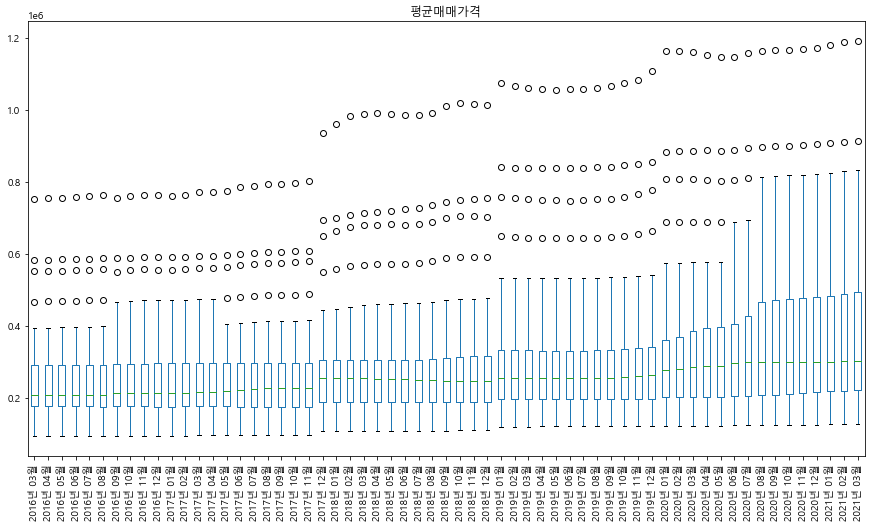

In [6]:
# 평균매매가격 boxplot
real_sale_price.iloc[:, 3:].boxplot(grid=False, rot=90, figsize=(15, 8))
plt.title('평균매매가격')

매매 가격에 대해 boxplot을 그려 전체적인 형태를 보았다. 시간이 흐름에 따라 매매 가격 격차가 커지는데, 특이점은 평균 매매가는 5년간 거의 변동이 없었다는 것이다.

Text(0.5, 1.0, '평균월세가격')

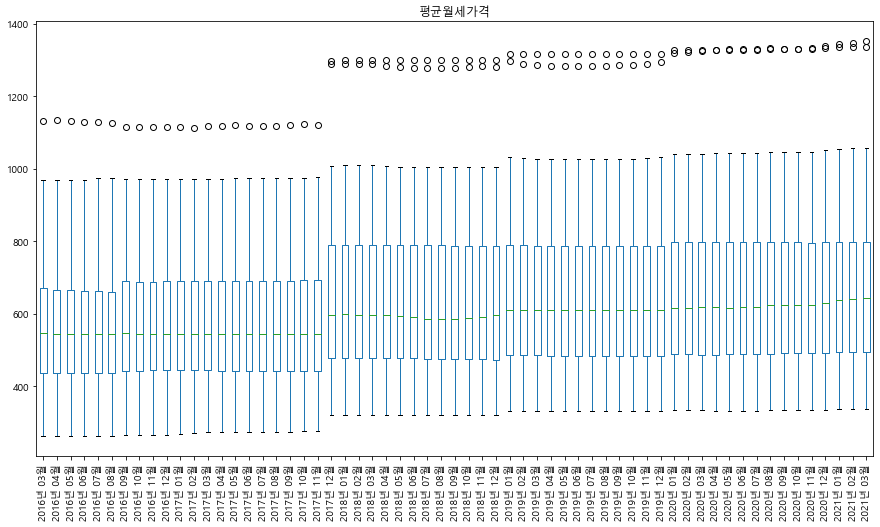

In [7]:
# 평균월세가격 boxplot
real_rent_price.iloc[:, 3:].boxplot(grid=False, rot=90, figsize=(15, 8))
plt.title('평균월세가격')

이번엔 월세 가격에 대해 boxplot을 그려 전체적인 형태를 보았다. 월세는 매매와는 달리 크게 변하지 않았다.

In [8]:
# 수익률을 계산해본다. (월세/매매가)*100으로 월 수익률을 계산한 뒤 12(개월)를 곱하여 연수익률을 계산하였다.
real_sale_price.iloc[:, 3:] = (np.array(real_rent_price.iloc[:,3:])/np.array(real_sale_price.iloc[:,3:]))*100*12
yield_rate = real_sale_price

In [9]:
# 한국은행 기준금리 크롤링 코드
# https://www.bok.or.kr/portal/singl/baseRate/list.do?dataSeCd=01&menuNo=200643

url = 'https://www.bok.or.kr/portal/singl/baseRate/list.do?dataSeCd=01&menuNo=200643'

resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'lxml')

# 기준금리 크롤링
link = soup.select('#content > div.table.tac > table')

# 테이블 html 정보를 문자열로 변경하기
table_html = str(link[0])

# 판다스의 read_html로 테이블 정보 읽기
table_df_list = pd.read_html(table_html)

# 데이터프레임 선택하기
base_rate = table_df_list[0]

In [10]:
# 2016.03 ~ 2021.03까지만 필요하므로 데이터를 자른다.
base_rate = base_rate.iloc[:8]
base_rate['날짜'] = base_rate['변경일자'].astype('str') + '년 ' + base_rate['변경일자.1'].str.split(' ').str[0]
base_rate.set_index('날짜', drop=True, inplace=True)

del base_rate['변경일자']
del base_rate['변경일자.1']

base_rate = base_rate.sort_values(by=['날짜'])
base_rate

c:\users\pc\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,기준금리
날짜,
2015년 06월,1.50
2016년 06월,1.25
2017년 11월,1.50
2018년 11월,1.75
2019년 07월,1.50
2019년 10월,1.25
2020년 03월,0.75
2020년 05월,0.50


In [11]:
# 한국은행 기준금리표를 바탕으로 기준금리에 대한 표를 새로 생성하였다. 15일을 기준으로 하였다.
real_rent_price.iloc[:, 3:6] = 1.50
real_rent_price.iloc[:, 6:24] = 1.25
real_rent_price.iloc[:, 24:36] = 1.50
real_rent_price.iloc[:, 36:44] = 1.75
real_rent_price.iloc[:, 44:47] = 1.50
real_rent_price.iloc[:, 47:50] = 1.25
real_rent_price.iloc[:, 50:54] = 0.75
real_rent_price.iloc[:, 54:] = 0.50

In [12]:
real_rent_price.iloc[:, 3:] = yield_rate.iloc[:, 3:] - real_rent_price.iloc[:, 3:]
yield_base_rate = real_rent_price

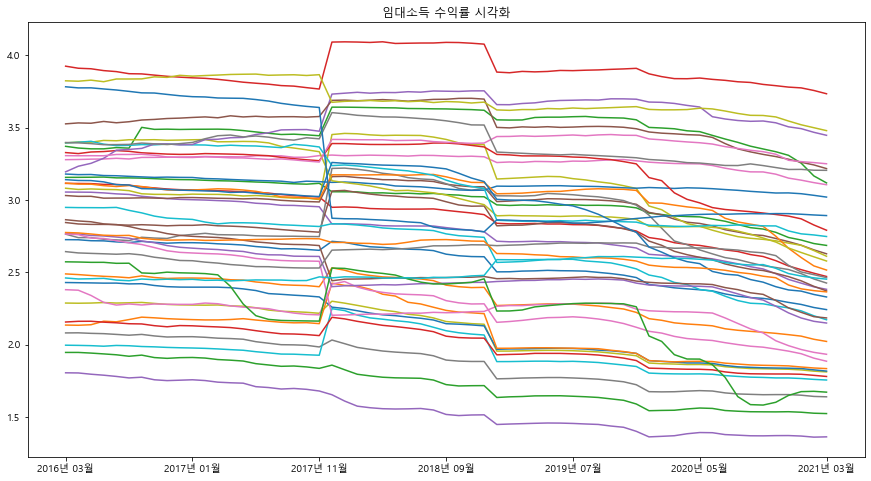

In [13]:
# 임대소득 수익률 시각화
plt.figure(figsize=(15, 8))
plt.title('임대소득 수익률 시각화')
for n in range(yield_rate.shape[0]):
    yield_rate.iloc[n, 3:].plot()

임대소득 수익률은 전체적으로 우하향했다. 매매 가격이 크게 증가한 것과는 달리 월세는 비슷한 가격을 유지했기 때문에, 당연한 결과이다.

<AxesSubplot:title={'center':'기준금리 시각화'}, xlabel='날짜'>

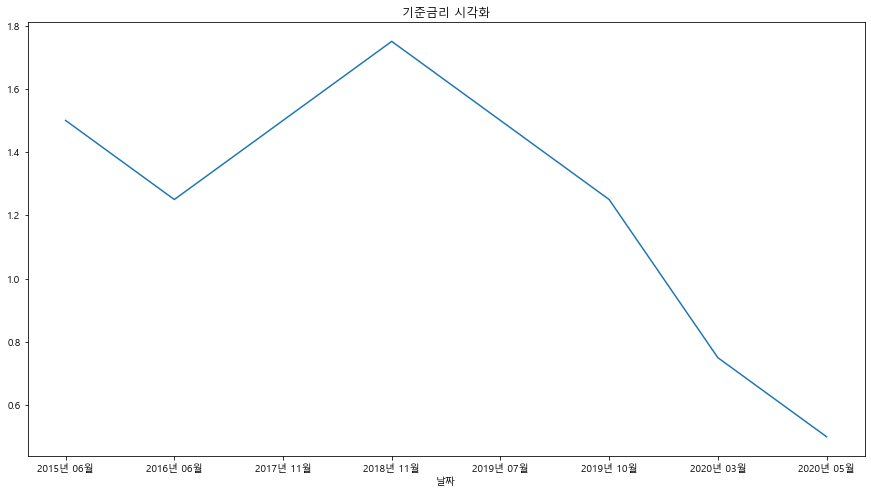

In [14]:
# 기준금리 시각화
plt.figure(figsize=(15, 8))
plt.title('기준금리 시각화')
base_rate['기준금리'].plot()

기준금리는 난도질 당했다.

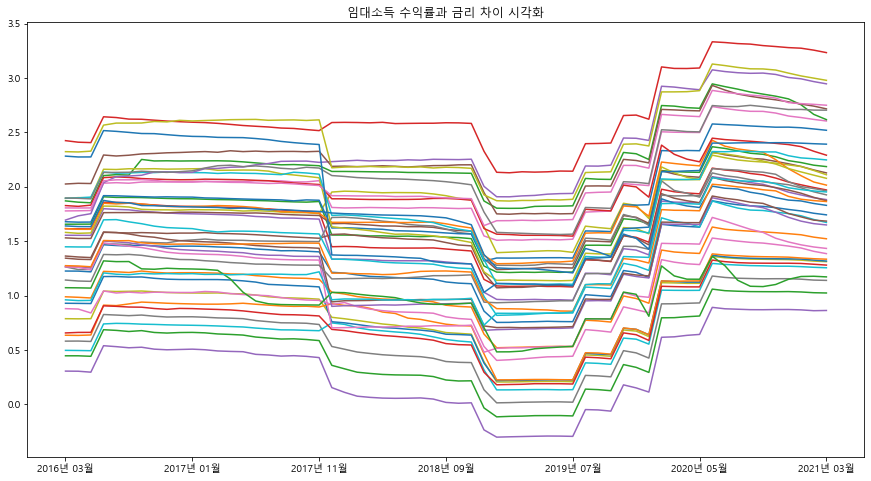

In [15]:
# 임대소득 수익률과 금리 차이 시각화
plt.figure(figsize=(15, 8))
plt.title('임대소득 수익률과 금리 차이 시각화')
for n in range(yield_base_rate.shape[0]):
    yield_base_rate.iloc[n, 3:].plot()

이전에는 크게 뛰어난 수익률을 내지 못했지만, 2019년 7월 이후부터는 은행금리와의 수익률 차이가 눈에 띄게 증가하였다.

c:\users\pc\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:title={'center':'전체평균수익률 시각화'}>

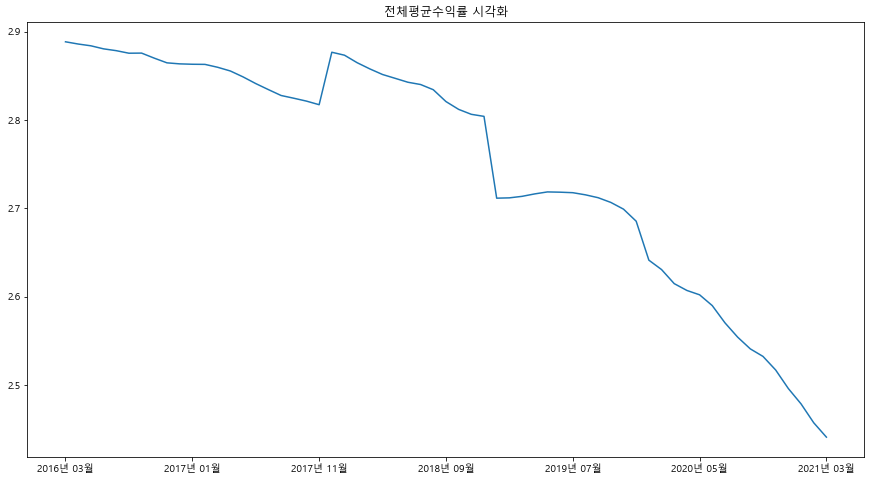

In [16]:
# 임대소득 수익률 전체 평균 시각화
yield_rate.loc[41, :] = yield_rate.iloc[:, 3:].mean(axis=0)
yield_rate['지 역'][41] = '전체평균수익률'

plt.figure(figsize=(15, 8))
plt.title('전체평균수익률 시각화')
yield_rate.iloc[41, 3:].plot()

### 결론
우리나라 전체 평균을 확인해보면, 임대소득 투자 수익률이 계속 하락하고 있다. 또한 위 계산식에는 다양한 세금, 수수료, 수리비 등 다른 고려해야 할 요소는 전혀 따지지 않았기 때문에 더 낮은 수익률이 예상된다. 보통 이상적인 임대 수익률은 3.5% 이상이라고들 한다. 그러므로 평균 수익률이 3%를 넘은 적이 없었던 최근 5년 사이 임대소득 투자법을 통해 주택에 투자했었다면 실패했을 가능성이 높다고 판단된다.

### 매매차익 투자법
이번에는 아파트 실거래가격지수, 주택매매가격지수(KB)를 보며 매매차익을 노리는 투자법을 진행했다면 투자에 성공했을지 확인해보자.

In [17]:
transaction_price = pd.read_csv(path + "아파트 실거래가격지수.csv")
sale_price = pd.read_csv(path + "주택매매가격지수(KB).csv")

transaction_price = transaction_price.iloc[122:,:]
sale_price = sale_price.iloc[362:,:]

transaction_price.rename(columns={'Unnamed: 0':'날짜'}, inplace=True)
sale_price.rename(columns={'Unnamed: 0':'날짜'}, inplace=True)

transaction_price.set_index('날짜', drop=True, inplace=True)
sale_price.set_index('날짜', drop=True, inplace=True)

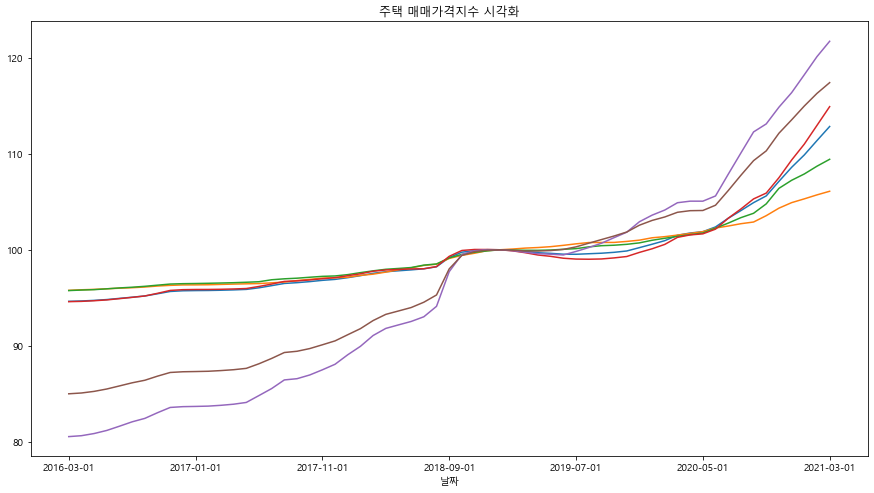

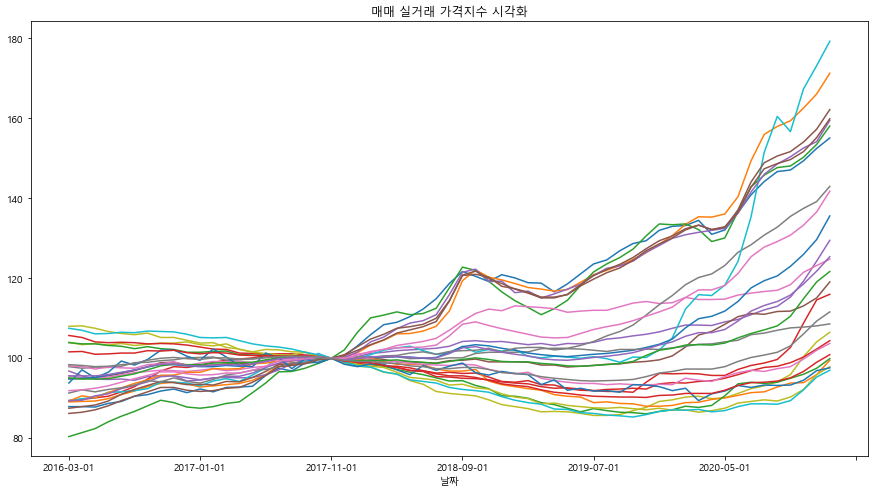

In [18]:
# 매매 실거래 가격지수와 주택 매매가격지수 시각화
    
plt.figure(figsize=(15, 8))
plt.title('주택 매매가격지수 시각화')
for n in range(sale_price.shape[1]):
    sale_price.iloc[:, n].plot()
    
plt.figure(figsize=(15, 8))
plt.title('매매 실거래 가격지수 시각화')
for n in range(transaction_price.shape[1]):
    transaction_price.iloc[:, n].plot()

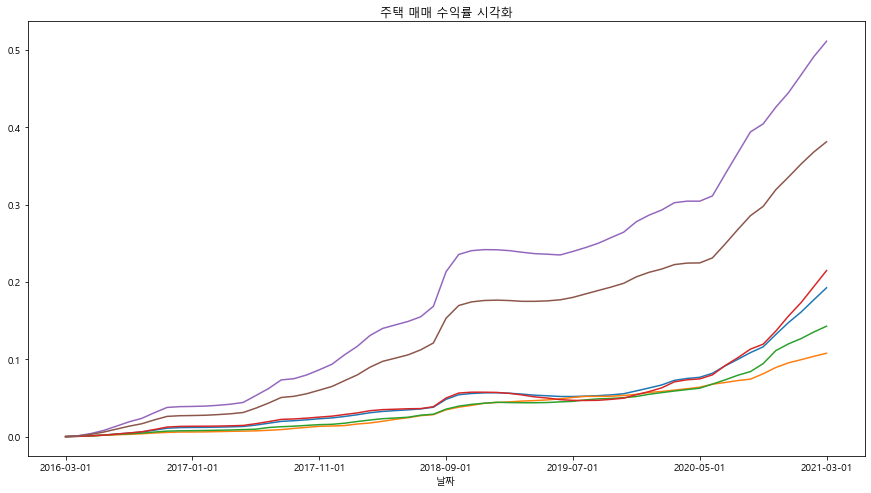

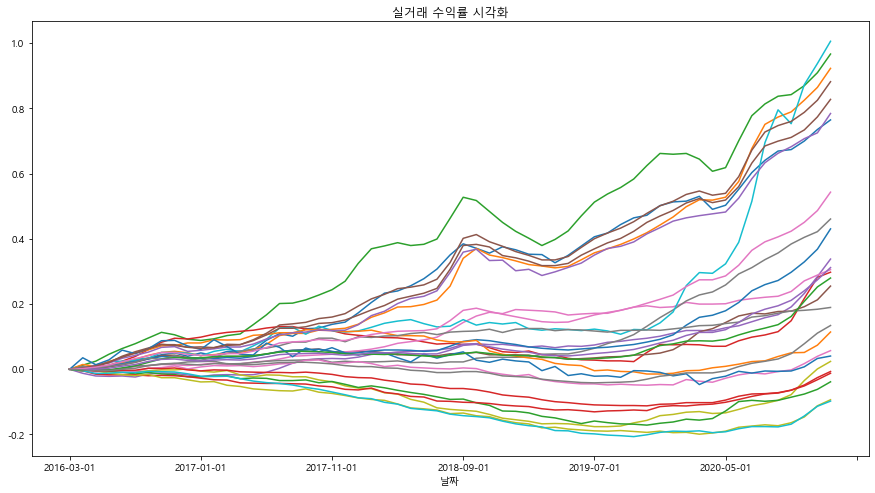

In [19]:
# 2016년 3월 1일을 기준으로 수익률을 계산한다면 다음과 같다.
    
plt.figure(figsize=(15, 8))
plt.title('주택 매매 수익률 시각화')
for n in range(sale_price.shape[1]):
    (sale_price/sale_price.iloc[0]-1).iloc[:, n].plot()
    
plt.figure(figsize=(15, 8))
plt.title('실거래 수익률 시각화')
for n in range(transaction_price.shape[1]):
    (transaction_price/transaction_price.iloc[0]-1).iloc[:, n].plot()

시각화 자료를 확인해 보면 주택 매매가격은 꾸준히 오르긴 했으나 실거래 가격은 절반의 지역에서 음의 수익률을 보인다.

### 결론
기간은 임대소득 투자법과 같이 비교하기 위해 2016년 3월부터 보았다. 주택 매매 가격지수는 우상향 하는 것을 볼 수 있으나, 실거래 가격 지수는 상향하는 지역은 끝 없이 상향하나 하향하는 곳은 잠시 하향했다가 다시 원래 자리를 찾아가는 형태를 보인다. 부동산 불패신화라고 하던가.... 어찌됐건 최근 5년 사이 매매차익 투자법을 통해 부동산에 투자하였다면 성공했을 가능성이 높다.

In [20]:
# 결론
profit = [key for key,value in ((transaction_price/transaction_price.iloc[0]-1).iloc[-1]).items() if value > 0.1]
loss = [key for key,value in ((transaction_price/transaction_price.iloc[0]-1).iloc[-1]).items() if value <= 0.1]

print([x.split(sep='[')[0] for x in profit], "에 해당하는 지역은 이득을 봤다고 할 수 있다.\n")
print([x.split(sep='[')[0] for x in loss], "에 해당하는 지역은 손실을 봤다고 할 수 있다.\n")

['도심권', '동북권', '동남권', '부산', '대구', '인천', '광주', '대전', '세종', '경기', '강원', '서북권', '서남권', '전남', '지방광역시', '전국', '서울', '수도권', '지방'] 에 해당하는 지역은 이득을 봤다고 할 수 있다.

['울산', '충북', '충남', '전북', '경북', '경남', '제주', '지방도'] 에 해당하는 지역은 손실을 봤다고 할 수 있다.



## 2. 땅 투자

요즘 하도 다른 투자(혹은 투기)들이 잘나가기 때문에, 땅 투자는 상대적으로 약세이다. 하지만 사실 땅 투자도 장점이 많다. 수 배에 달하는 수익률, 높은 가격 안정성, 소액 투자 가능 등이 장점이다.
<br>
<br>
땅을 투자하기 전 국토종합계획, 광역도시계획, 도시계획, 도시 기본계획, 도시관리 계획 등에 대한 개념은 기초적으로 숙지하고 있어야 한다. 물론 본인이 미래예지가 가능하다면 친척 명의만 있으면 된다. 일단 단순하게 땅값이 상승했던 달과 전체 달 수를 비교하여 수익 안정성을 확인해보자.

In [21]:
# 지역별 지가변동률 2016.03 ~ 2021.03 사이의 데이터를 불러온다.
land_price = pd.read_csv(path + "지역별_지가변동률.csv")
unsold = pd.read_csv(path + "미분양주택현황.csv")
construction_permit = pd.read_csv(path + "주택건설인허가실적.csv")

land_price.rename(columns={'Unnamed: 0':'날짜'}, inplace=True)
land_price = land_price.query('"2016-03-01"<=날짜<="2021-03-31"')
land_price.set_index('날짜', drop=True, inplace=True)

unsold.rename(columns={'Unnamed: 0':'날짜'}, inplace=True)
unsold = unsold.query('"2016-03-01"<=날짜<="2021-03-31"')
unsold.set_index('날짜', drop=True, inplace=True)

construction_permit.rename(columns={'Unnamed: 0':'날짜'}, inplace=True)
construction_permit = construction_permit.query('"2016-03-01"<=날짜<="2021-03-31"')
construction_permit.set_index('날짜', drop=True, inplace=True)

In [22]:
l_count = 0
for n in range(land_price.shape[0]-1):
    for m in range(1, land_price.shape[1]):
        if land_price.iloc[n, m]>0:
            l_count += 1
print("땅값이 상승한 달은 전체", land_price.shape[0]*land_price.shape[1], "개월 중에", l_count, "개월 이다.")
print("따라서", (l_count/(land_price.shape[0]*land_price.shape[1]))*100, "%의 확률로 투자 수익을 낼 수 있다.")

땅값이 상승한 달은 전체 1080 개월 중에 976 개월 이다.
따라서 90.37037037037037 %의 확률로 투자 수익을 낼 수 있다.


땅값과 미분양주택현황, 주택건설인허가실적은 서로 관련이 있을까? 비교해보도록 하자.

In [23]:
# 세 데이터셋에서 동일한 컬럼만 불러옵니다.

land_price_list = []
for lp in land_price.columns.tolist():
    temp = lp.replace('%','호')
    land_price_list.append(temp)

# 미분양주택현황, 주택건설인허가실적
unsold = unsold[land_price_list]
construction_permit = construction_permit[land_price_list]

# 미분양주택현황, 주택건설인허가실적에 대한 변동률
unsold = (unsold/unsold.iloc[0]-1)
construction_permit = (construction_permit/construction_permit.iloc[0]-1)

land_price.shape, unsold.shape, construction_permit.shape

((60, 18), (60, 18), (60, 18))

<AxesSubplot:title={'center':'주택건설인허가실적 시각화'}, xlabel='날짜'>

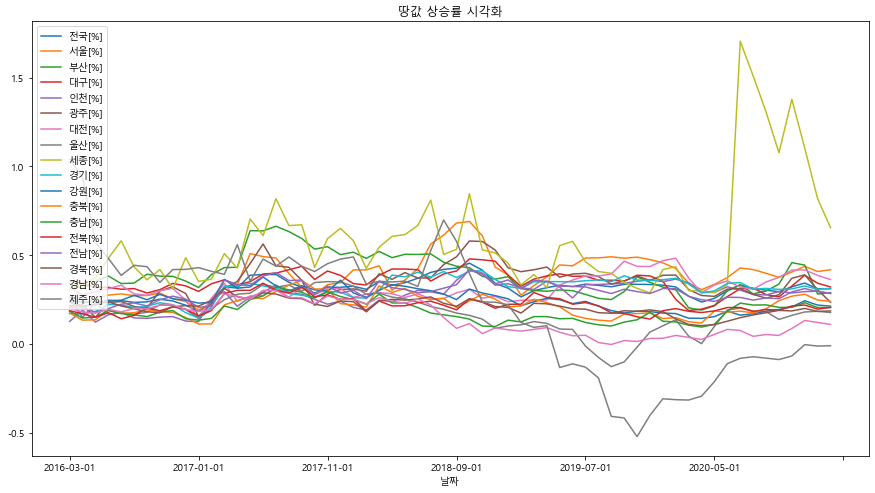

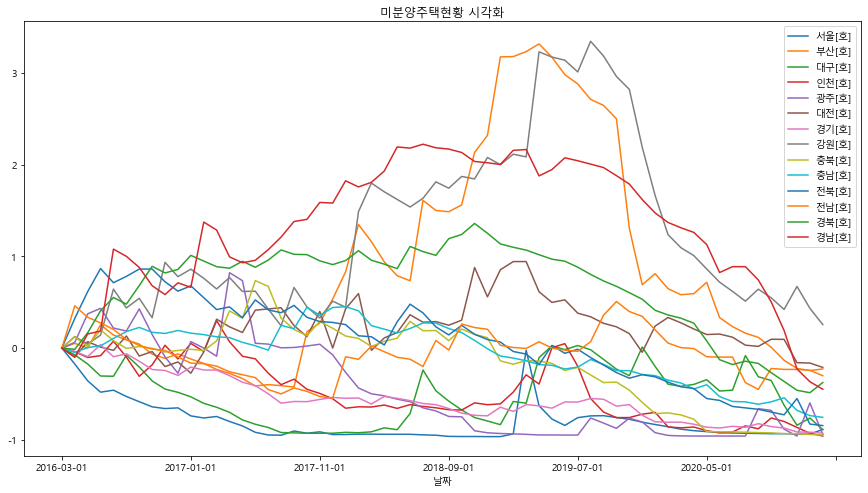

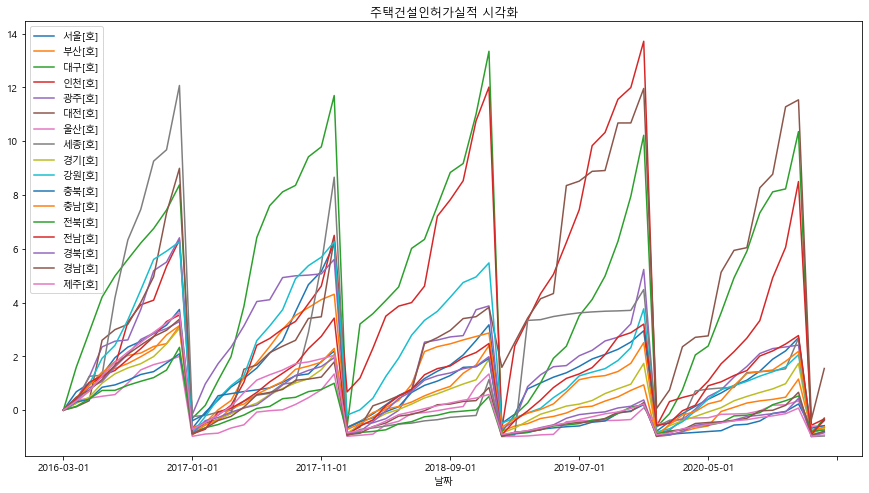

In [24]:
# 땅값 상승률 시각화
land_price.plot(title='땅값 상승률 시각화', figsize=(15, 8))

# 땅값 상승률 시각화: 세종/울산/제주는 outlier와 같은 느낌이여서 시각화에서 제외하였다.
unsold.drop(['전국[호]', '세종[호]', '울산[호]', '제주[호]'], axis=1).plot(title='미분양주택현황 시각화', figsize=(15, 8))

# 땅값 상승률 시각화
construction_permit.drop('전국[호]', axis=1).plot(title='주택건설인허가실적 시각화', figsize=(15, 8))

관련이 전혀 없다. 주택이 건설되던 말던 미분양이 쌓여서 유령도시가 되던 말던 오를 땅값은 오른다.

### 결론

땅값은 매달 꾸준히 상승해 왔으며, 투자하면 돈 잃을 확률이 10%에 그친다. 땅 투자, 조명 받지 못할 이유 없다.

## 3. 주식 투자

주식은 2016년 3월부터 2021년 3월까지 5년간의 5개국가별 지수를 보고 수익률과 안정성에 대해 판단해보겠다. 데이터는 파이썬 라이브러리인 __"FinanceDataReader"__ 를 활용하여 가져왔다.

In [25]:
%%time

# 데이터를 불러온다. 차례로 코스피/다우/항셍/영국FTSE/닛케이225선물이다.
kospi = fdr.DataReader('KS11', '2016-03-01', '2021-03-31')
dow = fdr.DataReader('DJI', '2016-03-01', '2021-03-31')
hongkong = fdr.DataReader('HSI', '2016-03-01', '2021-03-31')
ftse = fdr.DataReader('FTSE', '2016-03-01', '2021-03-31')
nikkei = fdr.DataReader('JP225', '2016-03-01', '2021-03-31')

Wall time: 5.17 s


<AxesSubplot:title={'center':'코스피 시각화'}, xlabel='Date'>

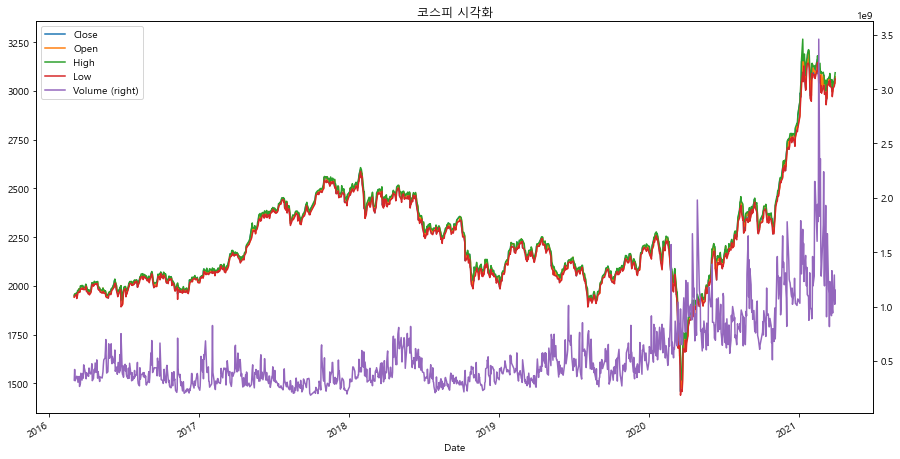

In [26]:
# 코스피 시각화. 거래량은 다른 secondary 축을 사용했다.
kospi[['Close', 'Open', 'High', 'Low', 'Volume']].plot(title='코스피 시각화', secondary_y='Volume', figsize=(15, 8))

<AxesSubplot:title={'center':'다우지수 시각화'}, xlabel='Date'>

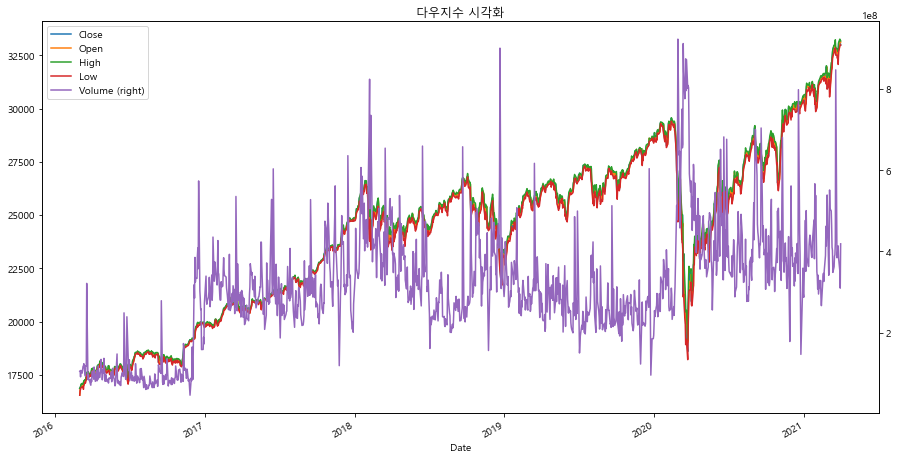

In [27]:
# 다우지수 시각화. 거래량은 다른 secondary 축을 사용했다.
dow[['Close', 'Open', 'High', 'Low', 'Volume']].plot(title='다우지수 시각화', secondary_y='Volume', figsize=(15, 8))

<AxesSubplot:title={'center':'홍콩지수 시각화'}, xlabel='Date'>

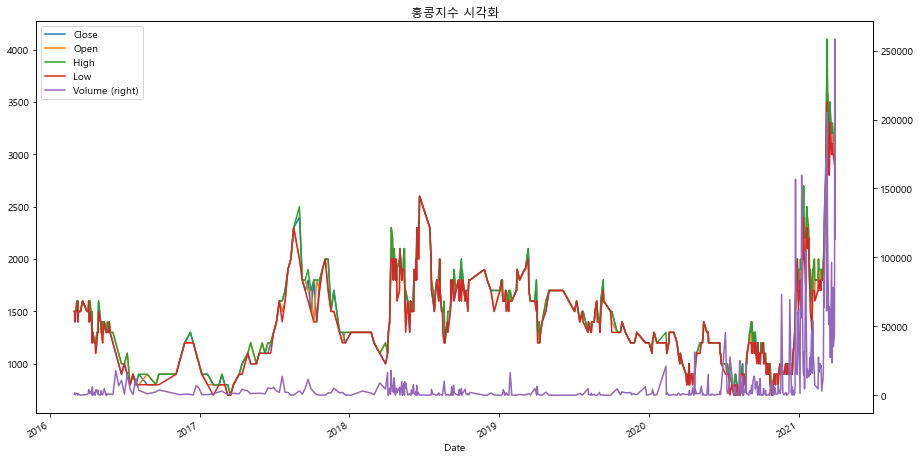

In [28]:
# 홍콩 시각화. 거래량은 다른 secondary 축을 사용했다.
hongkong[['Close', 'Open', 'High', 'Low', 'Volume']].plot(title='홍콩지수 시각화', secondary_y='Volume', figsize=(15, 8))

<AxesSubplot:title={'center':'영국FTSE 시각화'}, xlabel='Date'>

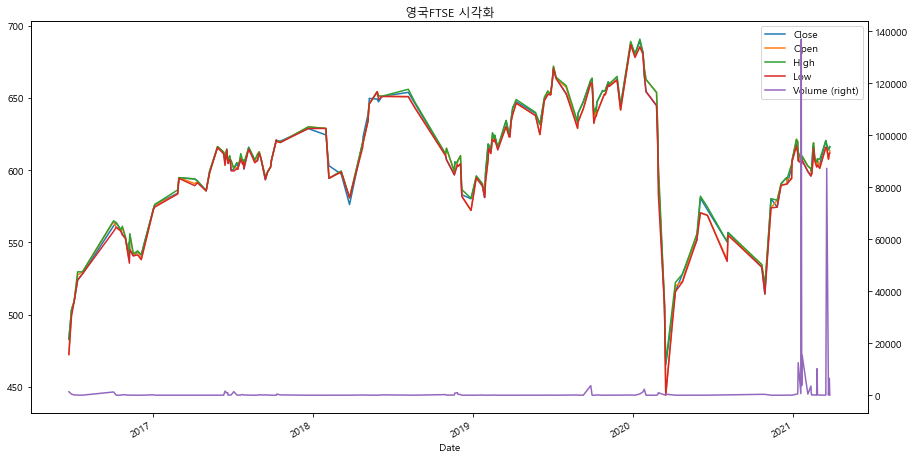

In [29]:
# 영국FTSE 시각화. 거래량은 다른 secondary 축을 사용했다.
ftse[['Close', 'Open', 'High', 'Low', 'Volume']].plot(title='영국FTSE 시각화', secondary_y='Volume', figsize=(15, 8))

<AxesSubplot:title={'center':'닛케이 시각화'}, xlabel='Date'>

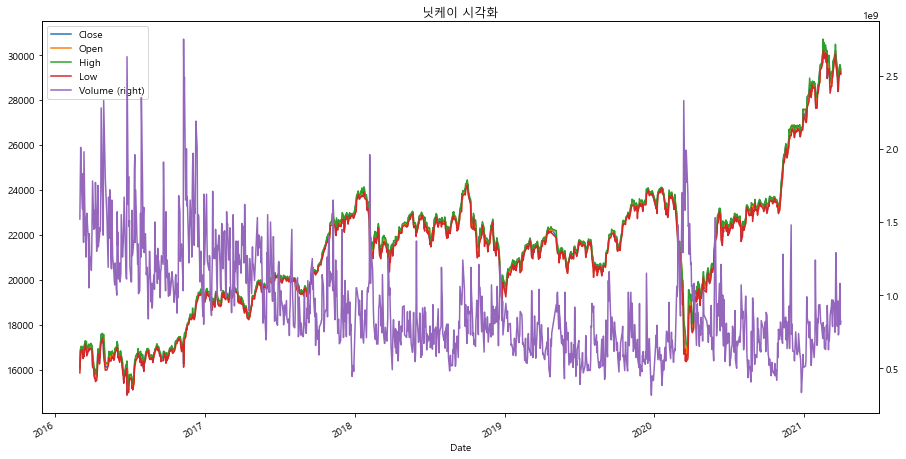

In [30]:
# 닛케이 시각화. 거래량은 다른 secondary 축을 사용했다.
nikkei[['Close', 'Open', 'High', 'Low', 'Volume']].plot(title='닛케이 시각화', secondary_y='Volume', figsize=(15, 8))

In [31]:
print_revenue(kospi, 'Close', '코스피지수')
print_revenue(dow, 'Close', '다우지수')
print_revenue(hongkong, 'Close', '홍콩지수')
print_revenue(ftse, 'Close', '영국FTSE')
print_revenue(nikkei, 'Close', '닛케이')

근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 코스피지수 수익률은 :  120.14969402595975 % 입니다.
근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 다우지수 수익률은 :  96.68670412473584 % 입니다.
근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 홍콩지수 수익률은 :  471.42857142857144 % 입니다.
근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 영국FTSE 수익률은 :  48.151332760103195 % 입니다.
근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 닛케이 수익률은 :  103.77012604317008 % 입니다.


가장 저점에서 사서 가장 고점에서 판 사람은 존재하지 않겠지만, 어찌 되었건 시각자료들을 확인해보면 영국 지수를 제외하면 전체적으로 우상향한 것을 확인할 수 있다. 각 지수들의 수익 안정성은 어떻게 될까? 단순하게 주식이 상승했던 날과 전체날 수를 비교하여 수익 안정성을 확인해보자.

In [32]:
print_safety(kospi, 'Close', '코스피')
print_safety(dow, 'Close', '다우지수')
print_safety(hongkong, 'Close', '홍콩지수')
print_safety(ftse, 'Close', '영국 FTSE')
print_safety(nikkei, 'Close', '닛케이 지수')

코스피가 상승한 날은 전체 1249 일 중에 686 일 이다.
따라서 54.92393915132106 %의 확률로 투자 수익을 낼 수 있다.
다우지수가 상승한 날은 전체 1281 일 중에 715 일 이다.
따라서 55.81576893052302 %의 확률로 투자 수익을 낼 수 있다.
홍콩지수가 상승한 날은 전체 481 일 중에 189 일 이다.
따라서 39.2931392931393 %의 확률로 투자 수익을 낼 수 있다.
영국 FTSE가 상승한 날은 전체 177 일 중에 90 일 이다.
따라서 50.847457627118644 %의 확률로 투자 수익을 낼 수 있다.
닛케이 지수가 상승한 날은 전체 1240 일 중에 660 일 이다.
따라서 53.2258064516129 %의 확률로 투자 수익을 낼 수 있다.


### 결론

홍콩 지수를 제외한 나머지 국가들은 반의 확률로 투자 수익을 낼 수 있었다. 물론 국가 지수를 가지고 단타를 하는 투자자는 없겠지만 홍콩 지수를 가지고 단타를 했을 경우 숏을 치지 않는 한 돈을 잃었을 확률이 크다.

## 4. 코인 투기
코인 투자에 앞서, 코인에 대한 기본 정보부터 보고 가겠다. 코인의 시초인 비트고인은 __"사토시 나카모토"__ 에 의해 2008년 10월 9쪽짜리 논문을 통해 공개되었다고 한다. 가장 큰 특징은 기존 화폐와 달리 정부나 중앙은행, 금융기관의 개입없이 개인간의 빠르고 안전한 거래가 가능하다는 것인데, 사실 이렇게만 들으면 얼마나 대단한 건지 한눈에 알기가 쉽지 않기 때문에, 다음 표를 준비했다.

|  <center></center> |  <center>매입사</center> |  <center>매입처리사</center> |  <center>카드네트워크</center> |  <center>발급사</center> |
|:--------:|:--------:|:--------:|:--------:|:--------:|
| **기존 카드결제** | ex) Chase | ex) Chase paymentech | ex) VISA, Master Card | ex) KB국민은행 |
| **비트코인** | 비트코인 | 비트코인 | 비트코인 | 비트코인 |

기존에는 고객이 결제를 하면 위와 같이 다양한 중계 업체들에 의해 수수료가 지불되어 왔으며, 중간 과정이 하나라도 누락되어서는 안되었다. 하지만 비트코인은 모든 것을 혼자 한다. 결제 생태계에 Game Changer가 나타난 것이다. 비트코인은 기술력도 대단하지만, 그 역할과 가치가 매우 크다고 볼 수 있으며 이는 결코 거품일 수가 없다.

In [33]:
# 빗썸의 pybithumb 라이브러리를 이용하여 시세를 불러와 보겠다. 빗썸에서 지원하는 암호화폐 목록이다.
print(Bithumb.get_tickers())

['BTC', 'ETH', 'LTC', 'ETC', 'XRP', 'BCH', 'QTUM', 'BTG', 'EOS', 'ICX', 'TRX', 'ELF', 'OMG', 'KNC', 'GLM', 'ZIL', 'WAXP', 'POWR', 'LRC', 'STEEM', 'STRAX', 'AE', 'ZRX', 'REP', 'XEM', 'SNT', 'ADA', 'CTXC', 'BAT', 'WTC', 'THETA', 'LOOM', 'WAVES', 'TRUE', 'LINK', 'RNT', 'ENJ', 'VET', 'MTL', 'IOST', 'TMTG', 'QKC', 'HDAC', 'AMO', 'BSV', 'DAC', 'ORBS', 'TFUEL', 'VALOR', 'CON', 'ANKR', 'MIX', 'LAMB', 'CRO', 'FX', 'CHR', 'MBL', 'MXC', 'DVP', 'FCT', 'FNB', 'TRV', 'PCM', 'DAD', 'AOA', 'WOM', 'SOC', 'EM', 'QBZ', 'BOA', 'FLETA', 'SXP', 'COS', 'APIX', 'EL', 'BASIC', 'HIVE', 'XPR', 'FIT', 'EGG', 'BORA', 'ARPA', 'APM', 'CKB', 'AERGO', 'ANW', 'CENNZ', 'EVZ', 'MCI', 'SRM', 'QTCON', 'UNI', 'YFI', 'UMA', 'AAVE', 'COMP', 'RLC', 'SAND', 'CVT', 'GOM2', 'RINGX', 'BEL', 'DVC', 'OBSR', 'ORC', 'POLA', 'AWO', 'ADP', 'DVI', 'MIR', 'MVC', 'WOZX', 'ANV', 'GRT', 'MM', 'BIOT', 'XNO', 'SNX', 'RAI', 'COLA', 'NU', 'OXT', 'LINA', 'MAP', 'AQT', 'MANA', 'LPT', 'MKR', 'SUSHI', 'ASM', 'PUNDIX', 'LF', 'ARW', 'RLY', 'OCEAN', 'A

코인 종류는 매우 많지만 가장 대표가 되는 3개만 살펴보겠다. 바로 비트코인(bitcoin), 이더리움(ethereum), 리플(ripple)로, 각각 "BTC", "ETH", "XRP"이다.

In [34]:
# 데이터를 불러 온 후 2016.03 ~ 2021.03의 기간을 살펴보자.
btc = Bithumb.get_candlestick("BTC")
eth = Bithumb.get_candlestick("ETH")
xrp = Bithumb.get_candlestick("XRP")

btc = btc.query('"2016-03-01"<= time <="2021-03-31"')
eth = eth.query('"2016-03-01"<= time <="2021-03-31"')
xrp = xrp.query('"2016-03-01"<= time <="2021-03-31"')

<AxesSubplot:title={'center':'비트코인 시각화'}, xlabel='time'>

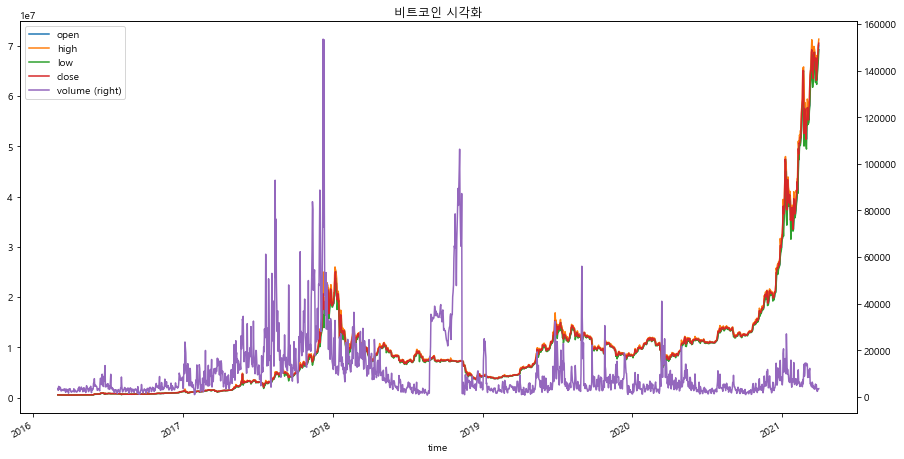

In [35]:
# 비트코인 시각화. 거래량은 다른 secondary 축을 사용했다.
btc.plot(title='비트코인 시각화', secondary_y="volume", figsize=(15, 8))

<AxesSubplot:title={'center':'이더리움 시각화'}, xlabel='time'>

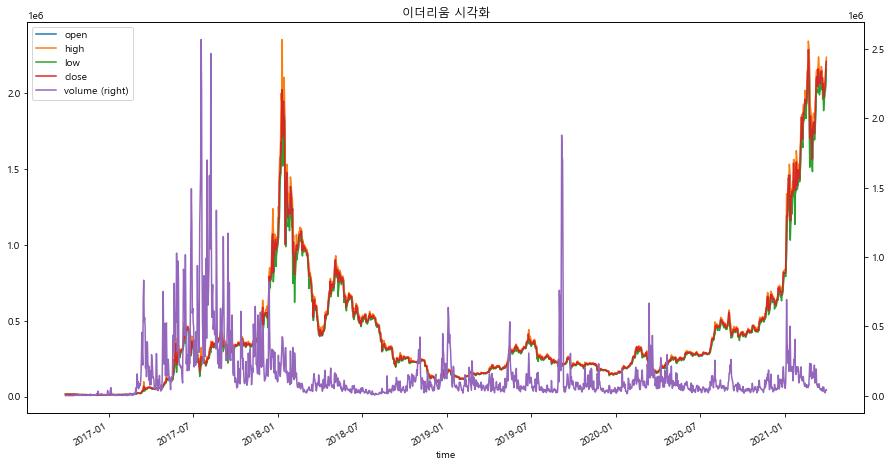

In [36]:
# 이더리움 시각화. 거래량은 다른 secondary 축을 사용했다.
eth.plot(title='이더리움 시각화', secondary_y="volume", figsize=(15, 8))

<AxesSubplot:title={'center':'리플 시각화'}, xlabel='time'>

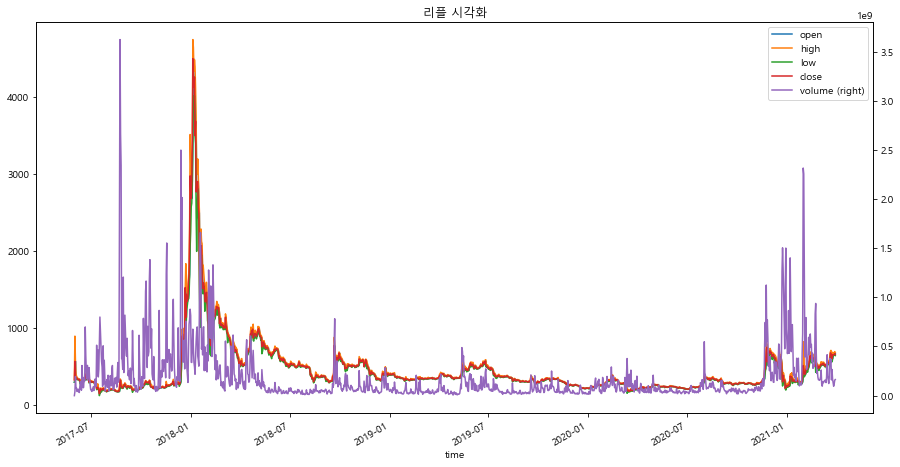

In [37]:
# 리플 시각화. 거래량은 다른 secondary 축을 사용했다.
xrp.plot(title='리플 시각화', secondary_y="volume", figsize=(15, 8))

In [38]:
print_revenue(btc, 'close', '비트코인')
print_revenue(eth, 'close', '이더리움')
print_revenue(xrp, 'close', '리플')

근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 비트코인 수익률은 :  14619.832985386221 % 입니다.
근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 이더리움 수익률은 :  27900.0 % 입니다.
근 5년 중 가장 저점에서 사서 가장 고점에서 팔았을 경우 리플 수익률은 :  2861.842105263158 % 입니다.


지금까지 볼 수 없었던, 그리고 앞으로도 볼 일 없는 어마어마한 수익률이다. 물론 존버를 통해 위와 같은 최대의 수익률을 낸 사람은 존재하지 않다고 봐도 무방하다. 특히 리플의 경우 2018년 1월 급상승 이후 급하락을 하였기에 존버를 하더라도 수익은 없는 수준이다.
<br>
<br>
수익률만 보자니 어질어질하다. 내가 돈을 잃었을 확률은 어떻게 될까? 역시나 단순하게 5년 중 가격이 상승한 날과 하락한 날을 비교하여 확률을 계산해보자.

In [39]:
print_safety(btc, 'close', '비트코인')
print_safety(eth, 'close', '이더리움')
print_safety(xrp, 'close', '리플')

비트코인가 상승한 날은 전체 1858 일 중에 1009 일 이다.
따라서 54.30570505920345 %의 확률로 투자 수익을 낼 수 있다.
이더리움가 상승한 날은 전체 1642 일 중에 839 일 이다.
따라서 51.09622411693058 %의 확률로 투자 수익을 낼 수 있다.
리플가 상승한 날은 전체 1402 일 중에 640 일 이다.
따라서 45.6490727532097 %의 확률로 투자 수익을 낼 수 있다.


### 결론

생각보다 돈을 벌 확률이 높다....!

## 5. 각 투자 간 상관성 분석

각 투자들은 서로 어떠한 연관성이 있을까? 연관성이 존재한다면 상관성이 있는 종목끼리 참고하며 투자할 경우 더 높은 안정성과 수익률을 낼 수 있을 것이다. 한번 수익률 간 상관관계에 대해 히트맵을 그려보자.

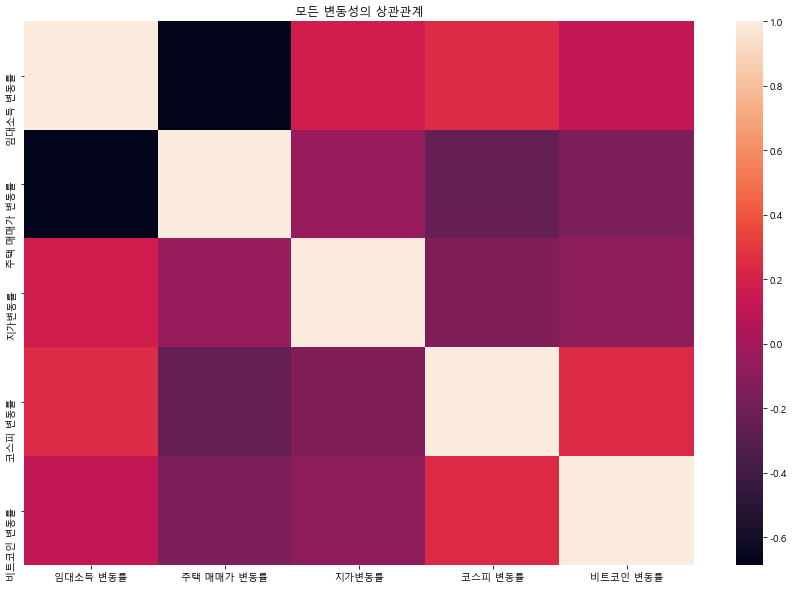

In [40]:
df_corr = np.vstack((
    np.array(np.array((((sale_price['총지수[2019.01=100]']-sale_price['총지수[2019.01=100]'].shift(1))/sale_price['총지수[2019.01=100]'])*100).iloc[1:-1])),
    np.array(yield_rate.iloc[41, 4:-1]),
    np.array(land_price['전국[%]'].iloc[1:]),
    np.array(kospi.resample('M').sum()['Change'].iloc[1:-1]),
    np.array((((btc.resample('M').mean()-btc.resample('M').mean().shift(1))/btc.resample('M').mean())*100)['close'].iloc[1:-1])
))

df_corr = pd.DataFrame(data=df_corr.T, columns=['임대소득 변동률','주택 매매가 변동률', '지가변동률', '코스피 변동률', '비트코인 변동률'])
corr = (df_corr*10000).applymap(round).corr()

plt.figure(figsize=(15, 10))
plt.title('모든 변동성의 상관관계')
sns.heatmap(corr)
plt.show()

색이 연할수록 상관관계가 높은 것인데, 솔직히 이정도면 서로 아무 관계가 없는 것 같다. 특히 임대소득 변동률과 주택 매매가 변동률, 지가 변동률은 서로 연관성이 클 줄 알았는데 의외의 결과이다. scatter plot을 그려보면 더 한눈에 들어온다.

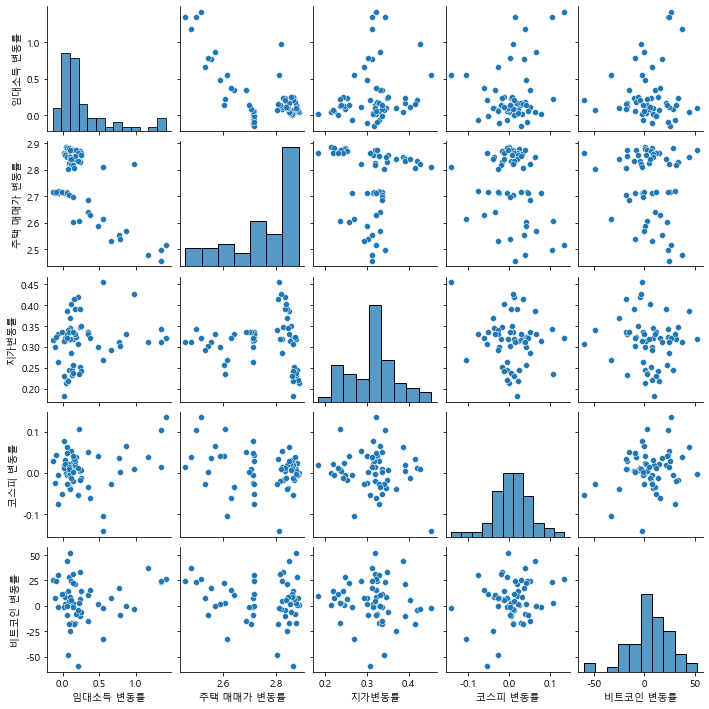

In [41]:
# scatterplot
sns.pairplot(df_corr, height = 2)
plt.show()

이렇게 보니 더욱더 강렬하게 연관성이 없어보인다.

# Outtro

지금까지 여러 투자에 대해 최근 5년간의 데이터를 가지고 분석해 보았다. 정리하자면 주택 투자는 매매차익 투자법을 사용했다면 투자에 성공했을 것이고, 땅 투자는 매달 꾸준한 상승률과 함께 매우 안정적인 자산의 형태를 유지했을 것이며, 주식 투자는 최고 수익률 홍콩지수 기준 471%, 최소 수익률 영국FTSE 기준 48%의 수익률을 냈으며, 마지막으로 코인 투자는 운이 좋은 사람에게는 27,900%의 엄청난 수익률을, 운이 나쁜 사람에게는 모든 돈을 다 잃는 결과를 냈을 것이다. 개인의 성향에 따라 안정성을 중시한다면 땅 투자를, 불나방이라면 코인 투자를 진행하면 되겠다.
<br>
<br>
여러 투자에 대해 비교를 하는 것이 내용의 주된 목적이다 보니, 사실 대회의 성격과는 조금 거리가 있다고 본다. 하지만 팀원 둘 다 투자에 관심이 많았고, 또 누군가에게 볼거리(?)를 제공한다 생각하니 이 과정 자체가 충분히 즐거웠다.

## Reference

[[초보투자자 40대 건물주 되기]부동산 투자 실전편: 임대소득 투자법 vs 매매차익 투자법](https://www.banksalad.com/contents/%EC%B4%88%EB%B3%B4-%ED%88%AC%EC%9E%90%EC%9E%90-40%EB%8C%80-%EA%B1%B4%EB%AC%BC%EC%A3%BC-%EB%90%98%EA%B8%B0-%EB%B6%80%EB%8F%99%EC%82%B0-%ED%88%AC%EC%9E%90-%EC%8B%A4%EC%A0%84%ED%8E%B8-%EC%9E%84%EB%8C%80%EC%86%8C%EB%93%9D-%ED%88%AC%EC%9E%90%EB%B2%95-vs-%EB%A7%A4%EB%A7%A4%EC%B0%A8%EC%9D%B5-%ED%88%AC%EC%9E%90%EB%B2%95-bQo2g)<br>
[부동산통계정보 R-ONE](https://www.r-one.co.kr/rone/resis/common/sub/sub.do?pageVal=page_7_1&combineTxt=%EC%9B%94%EC%84%B8)<br>
[한국은행 기준금리 추이](https://www.bok.or.kr/portal/singl/baseRate/list.do?dataSeCd=01&menuNo=200643)<br>
